In [1]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -U nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import tqdm as notebook_tqdm
import ipywidgets as widgets
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-04-06 15:20:07.219221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 15:20:07.219347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 15:20:07.365136: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
train_words = load_dataset("wmt16", "de-en", split="train[:50000]")
eval_words = load_dataset("wmt16", "de-en", split="validation")
test_words = load_dataset("wmt16", "de-en", split="test")

# dataset = load_dataset("wmt16", 'de-en')

# train_words = dataset['train']
# train_words = train_words.select(range(50000))
# eval_words = dataset['validation']
# test_words = dataset['test']

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/de-en/1.0.0/9e0038fe4cc117bd474d2774032cc133e355146ed0a47021b2040ca9db4645c0. Subsequent calls will reuse this data.


In [7]:
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [8]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [9]:
tokenized_train = train_words.map(preprocess_function, batched=True)
tokenized_eval= eval_words.map(preprocess_function, batched=True)
tokenized_test= test_words.map(preprocess_function, batched=True)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [11]:
blue = evaluate.load("bleu")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
                          
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result_bleu = blue.compute(predictions=decoded_preds, references=decoded_labels)
    result_meteor = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    result_BERT = bertscore.compute(predictions=decoded_preds, references=decoded_labels, model_type="distilbert-base-uncased")
    
    result = {"bleu": result_bleu['bleu'], 
              "blue1": result_bleu['precisions'][0],
              "blue2": result_bleu['precisions'][1],
              "blue3": result_bleu['precisions'][2],
              "meteor": result_meteor['meteor'],
              "BERT_precision": sum(result_BERT['precision'])/len(result_BERT['precision']),
              "BERT_recall": sum(result_BERT['recall'])/len(result_BERT['recall']),
              "BERT_F1": sum(result_BERT['f1'])/len(result_BERT['f1'])}
    
    return result


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [12]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
# print(model)

for i, param in enumerate(model.parameters()):
    if i < 35:
        param.requires_grad=False
#     print(i, param.requires_grad)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [13]:
print( model.encoder.block[0].layer[1])

T5LayerFF(
  (DenseReluDense): T5DenseActDense(
    (wi): Linear(in_features=512, out_features=2048, bias=False)
    (wo): Linear(in_features=2048, out_features=512, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
    (act): ReLU()
  )
  (layer_norm): T5LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [14]:
training_args = Seq2SeqTrainingArguments(
    output_dir="translation",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
#     weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    logging_strategy='epoch'
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Bleu,Blue1,Blue2,Blue3,Meteor,Bert Precision,Bert Recall,Bert F1
1,2.281400,2.097246,0.093470,0.507965,0.223282,0.114598,0.334130,0.842762,0.812528,0.826824
2,2.022200,2.067564,0.098236,0.512032,0.227907,0.120256,0.342009,0.846086,0.814863,0.829647
3,1.902400,2.054541,0.100098,0.518666,0.233587,0.122762,0.347958,0.850010,0.818825,0.833592
4,1.819100,2.060285,0.100214,0.517744,0.232376,0.122738,0.345997,0.849167,0.817241,0.832352
5,1.754700,2.065688,0.101923,0.520731,0.238427,0.126463,0.350836,0.851935,0.818873,0.834517
6,1.701100,2.057615,0.101244,0.520461,0.237007,0.124975,0.352468,0.851051,0.819307,0.834326
7,1.658000,2.068861,0.103675,0.521545,0.239132,0.126888,0.354197,0.852448,0.820909,0.835828
8,1.621400,2.070948,0.103847,0.520672,0.238482,0.128437,0.352080,0.852255,0.820163,0.835355
9,1.593300,2.077894,0.104132,0.524550,0.240790,0.127508,0.356886,0.853965,0.821195,0.836705
10,1.573900,2.079914,0.104262,0.524079,0.240034,0.127490,0.357652,0.853522,0.821368,0.836587


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=7820, training_loss=1.7927633222106778, metrics={'train_runtime': 3519.9674, 'train_samples_per_second': 142.047, 'train_steps_per_second': 2.222, 'total_flos': 1.6048636264710144e+16, 'train_loss': 1.7927633222106778, 'epoch': 10.0})

In [15]:
trainer.save_model("translation")

In [16]:
loaded_model = AutoModelForSeq2SeqLM.from_pretrained('translation/checkpoint-7500')

In [17]:
test_trainer = Seq2SeqTrainer(
    model=loaded_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [18]:
trainer.predict(tokenized_test)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


PredictionOutput(predictions=array([[    0,  4534,     3, ...,     0,     0,     0],
       [    0,    37,  1675, ...,     0,     0,     0],
       [    0,    37,   192, ...,  3629,    16,     8],
       ...,
       [    0,    37,  6145, ..., 17565,    11,  2744],
       [    0,  2506,   215, ...,  2196,   533,  5217],
       [    0,  3139,  9237, ...,  9237,     5,   221]]), label_ids=array([[4534,  911,    7, ..., -100, -100, -100],
       [  37, 1675,  344, ..., -100, -100, -100],
       [  37,  192, 1114, ..., -100, -100, -100],
       ...,
       [  37, 6145,   13, ..., -100, -100, -100],
       [  86,    8,  657, ..., -100, -100, -100],
       [3139, 9237,   19, ..., -100, -100, -100]]), metrics={'test_loss': 1.8900948762893677, 'test_bleu': 0.1176902477974404, 'test_blue1': 0.5390108310169655, 'test_blue2': 0.26024320346990937, 'test_blue3': 0.14263726423014497, 'test_meteor': 0.38249815026450706, 'test_BERT_precision': 0.8587252095207527, 'test_BERT_recall': 0.8270820666846135,

In [20]:
df_log_history = pd.DataFrame(trainer.state.log_history)

training_logs = df_log_history[df_log_history['loss'].notnull()]
training_loss = training_logs['loss'].tolist()
training_epochs = training_logs['epoch'].tolist()

eval_logs = df_log_history[df_log_history['eval_loss'].notnull()]
eval_loss = eval_logs['eval_loss'].tolist()
eval_epochs = eval_logs['epoch'].tolist()

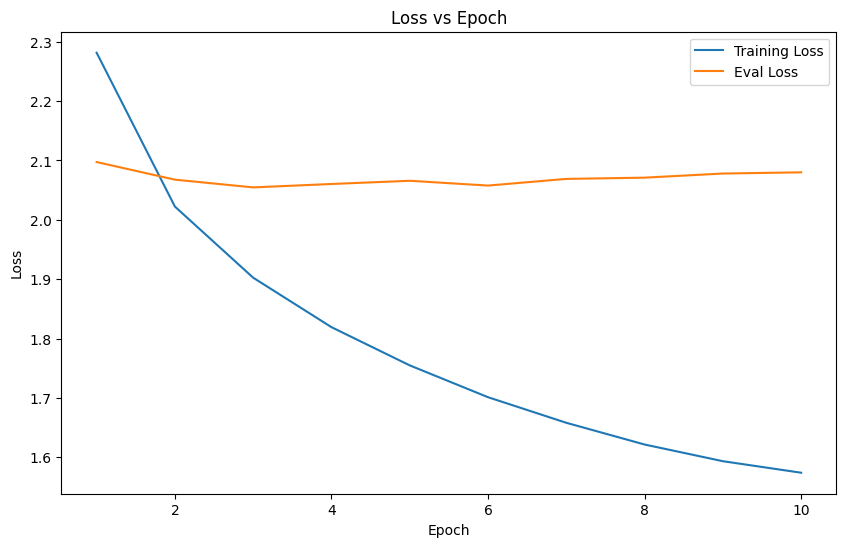

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(training_epochs, training_loss, label='Training Loss')
plt.plot(eval_epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()